# FRED Data Analysis Project
This notebook handles data retrieval, processing, and analysis for the FRED project.

# Imports and project set-up

In [1]:
import os
import sys
import requests
from datetime import datetime
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as web
from fpdf import FPDF
from PIL import Image

In [2]:
# Determine the main project folder (one level above the notebooks/ folder)
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_dir = os.path.abspath(os.path.join(notebook_dir, ".."))

# Define folders relative to the main project directory
data_dir = os.path.join(project_dir, "data")
results_dir = os.path.join(project_dir, "results")
scripts_dir = os.path.join(project_dir,"scripts")

# Add the project directory to the Python path
sys.path.insert(0, project_dir)

# Add folder to the Python path
if scripts_dir not in sys.path:
    sys.path.append(scripts_dir)

if results_dir not in sys.path:
    sys.path.append(results_dir)
    
# print("Folders added to sys.path:")
# print("\n".join(sys.path))
#print(sys.path)

In [3]:
# Create folders if they don't exist
for folder in [data_dir, results_dir, scripts_dir]:
    os.makedirs(folder, exist_ok=True)

print(f"Project directory: {project_dir}")
print(f"Data directory: {data_dir}")
print(f"Results directory: {results_dir}")
print(f"Scripts directory: {scripts_dir}")


Project directory: /data/data/com.termux/files/home/projects/fred_data_project
Data directory: /data/data/com.termux/files/home/projects/fred_data_project/data
Results directory: /data/data/com.termux/files/home/projects/fred_data_project/results
Scripts directory: /data/data/com.termux/files/home/projects/fred_data_project/scripts


In [4]:
# Set up fred environment
import fred_config

Fred class loaded: <class 'fredapi.fred.Fred'>


In [5]:
# Load charting config
from charting import create_chart

In [6]:
# Load tables config 

from tables import create_comparison_table
from tables import create_analysis_table

In [7]:
# PDF creator config

from pdf_report import PDFReportGenerator, create_report 

# Data loading

In [8]:
# Fetch the FRED data for US yields

series_ids = ["DFF","DGS3MO","DGS1","DGS2", "DGS5","DGS7","DGS10"]
us_yields = fred_config.fetch_fred_data(series_ids, start_date="", frequency="",force_refresh=False,results_dir=data_dir)

#us_yields.rename(columns=fred_config.FRED_SERIES, inplace=True)


Loading cached data from /data/data/com.termux/files/home/projects/fred_data_project/data/fred_data_DFF_DGS1_DGS10_DGS2_DGS3MO_DGS5_DGS7_all_native.csv


In [9]:
# Print yields
print(us_yields.head())  # Inspect the first few rows


             DFF  DGS3MO  DGS1  DGS2  DGS5  DGS7  DGS10
1954-07-01  1.13     NaN   NaN   NaN   NaN   NaN    NaN
1954-07-02  1.25     NaN   NaN   NaN   NaN   NaN    NaN
1954-07-03  1.25     NaN   NaN   NaN   NaN   NaN    NaN
1954-07-04  1.25     NaN   NaN   NaN   NaN   NaN    NaN
1954-07-05  0.88     NaN   NaN   NaN   NaN   NaN    NaN


In [10]:
# Fetch US corporate yields

series_ids = ["BAMLC0A1CAAAEY","BAMLC0A2CAAEY", "BAMLC0A3CAEY","BAMLC0A4CBBBEY","BAMLH0A1HYBBEY","BAMLH0A2HYBEY","BAMLH0A3HYCEY"]
us_corp_yields = fred_config.fetch_fred_data(series_ids, start_date="", frequency="",force_refresh=False,results_dir=data_dir)

#us_yields.rename(columns=fred_config.FRED_SERIES, inplace=True)


Loading cached data from /data/data/com.termux/files/home/projects/fred_data_project/data/fred_data_BAMLC0A1CAAAEY_BAMLC0A2CAAEY_BAMLC0A3CAEY_BAMLC0A4CBBBEY_BAMLH0A1HYBBEY_BAMLH0A2HYBEY_BAMLH0A3HYCEY_all_native.csv


In [11]:
# Print yields
print(us_corp_yields.head())  # Inspect the first few rows


            BAMLC0A1CAAAEY  BAMLC0A2CAAEY  BAMLC0A3CAEY  BAMLC0A4CBBBEY  \
1996-12-31            6.72           6.82          6.97            7.26   
1997-01-01             NaN            NaN           NaN             NaN   
1997-01-02            6.80           6.92          7.06            7.36   
1997-01-03            6.80           6.90          7.04            7.34   
1997-01-06            6.80           6.92          7.06            7.37   

            BAMLH0A1HYBBEY  BAMLH0A2HYBEY  BAMLH0A3HYCEY  
1996-12-31            8.36          10.01          13.97  
1997-01-01             NaN            NaN            NaN  
1997-01-02            8.43          10.00          13.95  
1997-01-03            8.43          10.01          14.02  
1997-01-06            8.45          10.05          14.03  


In [12]:
# Fetch US corporate spreads

series_ids = ["BAMLC0A1CAAA","BAMLC0A2CAA", "BAMLC0A3CA","BAMLC0A4CBBB","BAMLH0A1HYBB","BAMLH0A2HYB","BAMLH0A3HYC"]
us_corp_spreads = fred_config.fetch_fred_data(series_ids, start_date="", frequency="",force_refresh=False,results_dir=data_dir)

#us_yields.rename(columns=fred_config.FRED_SERIES, inplace=True)


Loading cached data from /data/data/com.termux/files/home/projects/fred_data_project/data/fred_data_BAMLC0A1CAAA_BAMLC0A2CAA_BAMLC0A3CA_BAMLC0A4CBBB_BAMLH0A1HYBB_BAMLH0A2HYB_BAMLH0A3HYC_all_native.csv


# Data processing

# Analysis

In [13]:
# Term spread creation

# Initialize the new DataFrame to store spreads
us_term_spreads = pd.DataFrame(index=us_yields.index)

# Loop over each column in us_yields
for column in us_yields.columns:
    # Create the spread series
    spread10_series = us_yields["DGS10"]-us_yields[column]
    spread5_series = us_yields["DGS5"]-us_yields[column]
    spread2_series= us_yields["DGS2"]-us_yields[column]
    spread3m_series= us_yields["DGS3MO"]-us_yields[column]
    # Add the spread series to the new DataFrame
    us_term_spreads[f"10_{column}"] = spread10_series
    us_term_spreads[f"5_{column}"] = spread5_series
    us_term_spreads[f"2_{column}"] = spread2_series
    us_term_spreads[f"3M_{column}"] = spread3m_series


# Verify the output
print(us_term_spreads.head())

#Create a dictionary for certain term spreads
term_spread_names = {
    "10_DGS5": "10Y less 5Y Spread",
    "10_DGS2": "10Y less 2Y Spread",
    "10_DGS3MO": "10Y less 3M Spread",
    "5_DGS2": "5Y less 2Y Spread",
    "5_DGS3MO": "5Y less 3M Spread",
    "2_DGS3MO": "2Y less 3M Spread",
    "2_DFF": "2Y less Fed Funds Rate Spread",
    "3M_DFF": "3M less Fed Funds Rate Spread"
    }

print(term_spread_names)
    

            10_DFF  5_DFF  2_DFF  3M_DFF  10_DGS3MO  5_DGS3MO  2_DGS3MO  \
1954-07-01     NaN    NaN    NaN     NaN        NaN       NaN       NaN   
1954-07-02     NaN    NaN    NaN     NaN        NaN       NaN       NaN   
1954-07-03     NaN    NaN    NaN     NaN        NaN       NaN       NaN   
1954-07-04     NaN    NaN    NaN     NaN        NaN       NaN       NaN   
1954-07-05     NaN    NaN    NaN     NaN        NaN       NaN       NaN   

            3M_DGS3MO  10_DGS1  5_DGS1  ...  2_DGS5  3M_DGS5  10_DGS7  5_DGS7  \
1954-07-01        NaN      NaN     NaN  ...     NaN      NaN      NaN     NaN   
1954-07-02        NaN      NaN     NaN  ...     NaN      NaN      NaN     NaN   
1954-07-03        NaN      NaN     NaN  ...     NaN      NaN      NaN     NaN   
1954-07-04        NaN      NaN     NaN  ...     NaN      NaN      NaN     NaN   
1954-07-05        NaN      NaN     NaN  ...     NaN      NaN      NaN     NaN   

            2_DGS7  3M_DGS7  10_DGS10  5_DGS10  2_DGS10  3M_DG

# US Gov Yields Charts and Tables

Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/DFF_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/DGS3MO_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/DGS1_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/DGS2_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/DGS5_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/DGS7_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/DGS10_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/us_yields_chart.png


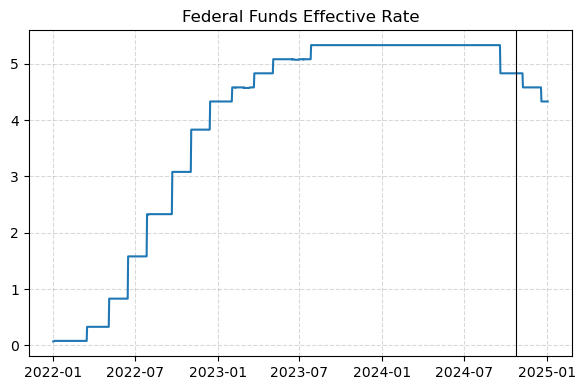

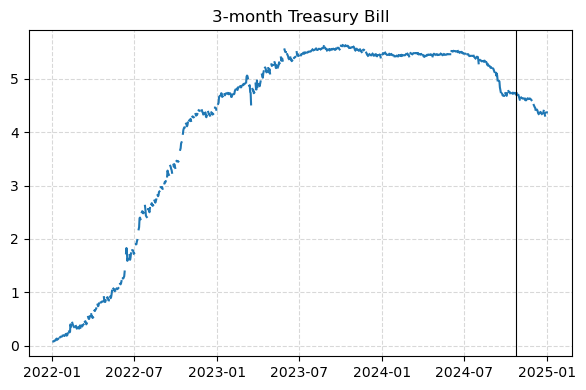

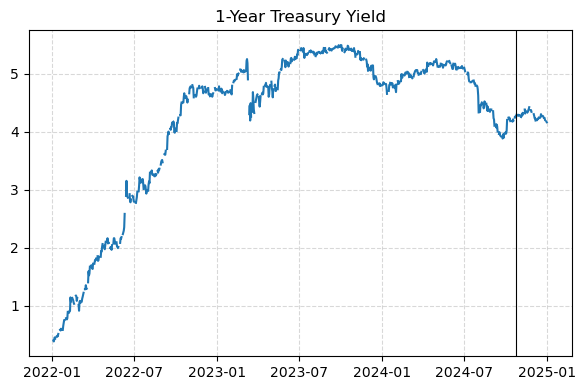

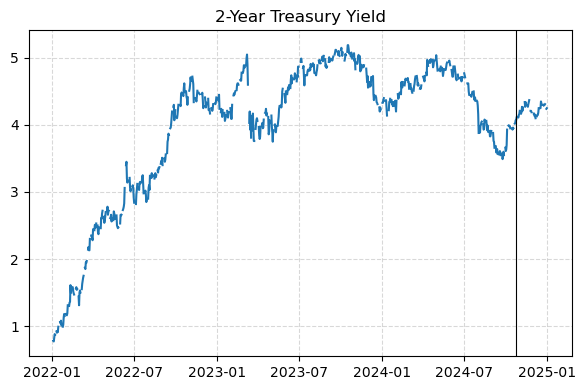

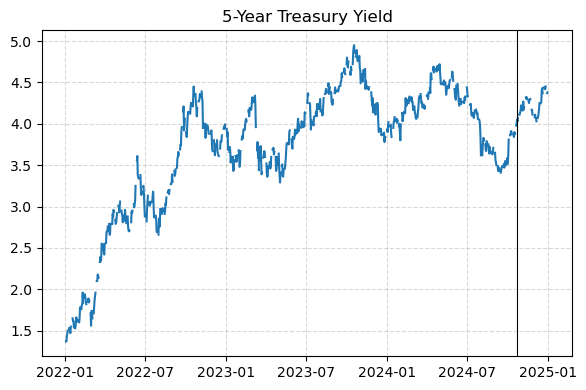

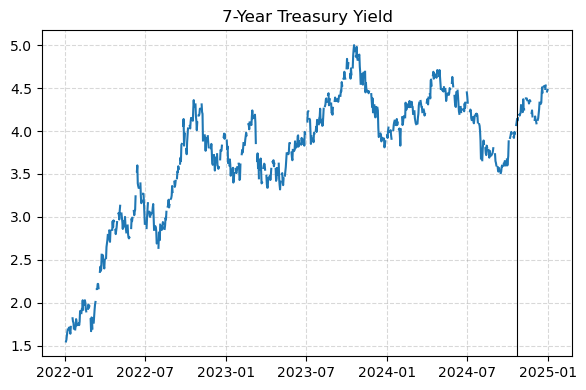

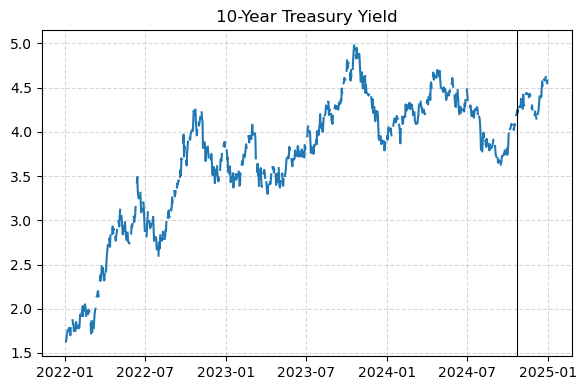

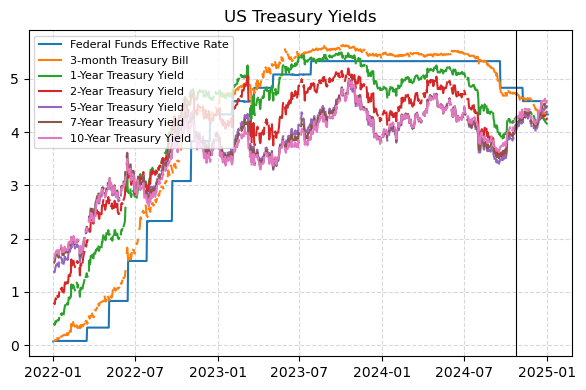

In [14]:
# US yields charts

# Extract column names from the DataFrame
us_yields_ids = us_yields.columns.tolist()

# Set chart parameters
vline = ["2024-10-23"]
custom_dates = ["2024-12-11", "2024-10-23","2024-09-4","2024-07-24","2024-04-10"]  # dates to include in tables
start_date = "2022-01-01"

# Loop to create individual charts for each series
for series in us_yields_ids:
    create_chart(us_yields, [series], start_date=start_date, show_data_label=False,
                 title=None, vlines=vline, show_table=False, custom_dates=custom_dates,
                 save_path=f"{results_dir}/{series}_chart.png")

# Create a single chart for the entire group
create_chart(us_yields, us_yields_ids, start_date=start_date, title="US Treasury Yields",
             show_data_label=False, vlines=vline, show_table=False, custom_dates=custom_dates,
             save_path=f"{results_dir}/us_yields_chart.png")


In [15]:
# All yields table
title = "Treasury Yield Current Values and Change vs. Certain Dates"
output_file = f"{results_dir}/us_yields_table.png"

create_comparison_table(us_yields, us_yields_ids, custom_dates, title, output_file)


Table saved to /data/data/com.termux/files/home/projects/fred_data_project/results/us_yields_table.png


In [16]:
# 10-year table

start_date = "2024-10-23"
series = "DGS10"
save_path = f"{results_dir}/{series}_table.png"
# Generate the table
create_analysis_table(series, start_date, us_yields,save_path)


Table saved to /data/data/com.termux/files/home/projects/fred_data_project/results/DGS10_table.png


In [17]:
# 2-year yield table

start_date = "2024-10-23"
series = "DGS2"
save_path = f"{results_dir}/{series}_table.png"
# Generate the table
create_analysis_table(series, start_date, us_yields,save_path)


Table saved to /data/data/com.termux/files/home/projects/fred_data_project/results/DGS2_table.png


# US Term Spread Charts and Tables

Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/10_DGS5_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/10_DGS2_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/10_DGS3MO_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/10_DFF_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/5_DGS2_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/5_DGS3MO_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/5_DFF_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/2_DGS3MO_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/2_DFF_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/

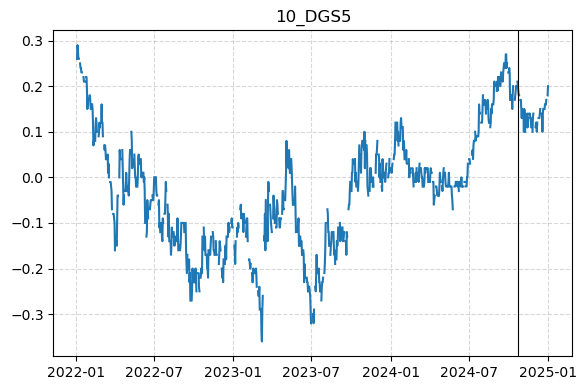

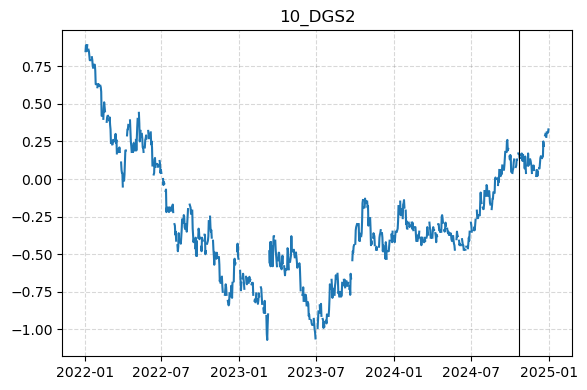

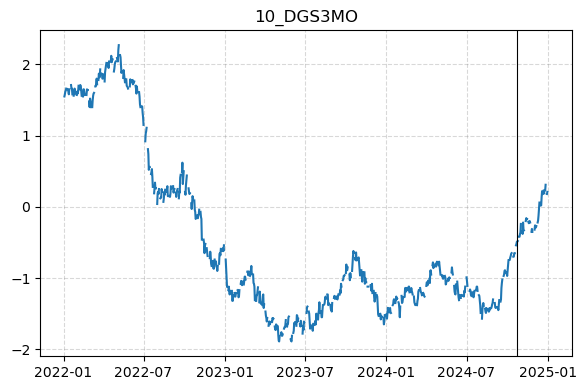

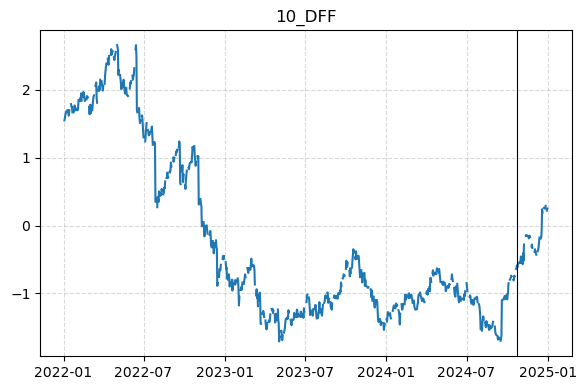

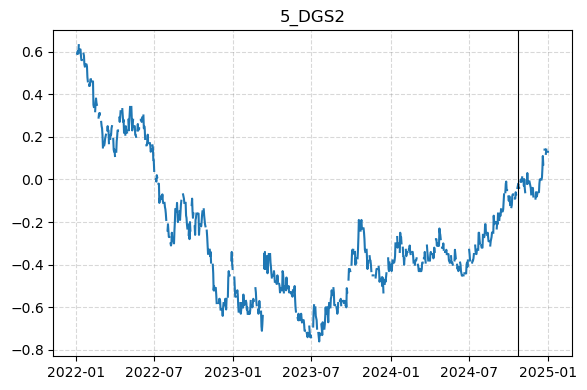

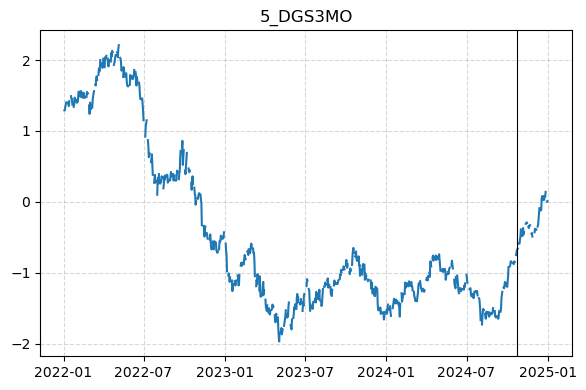

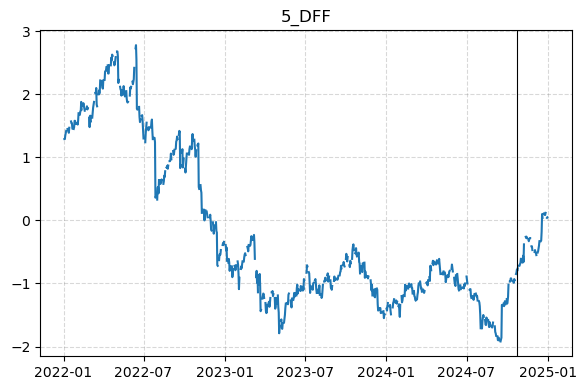

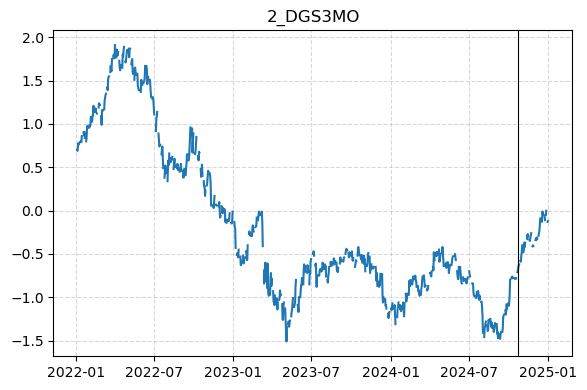

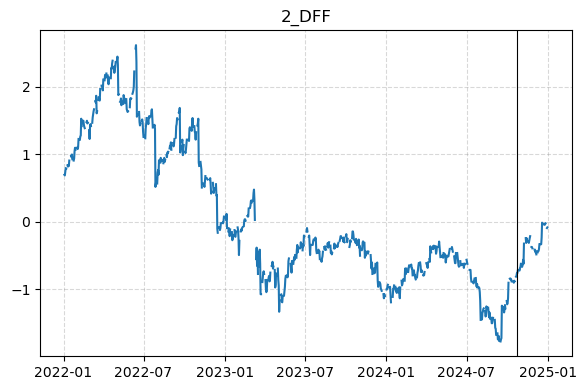

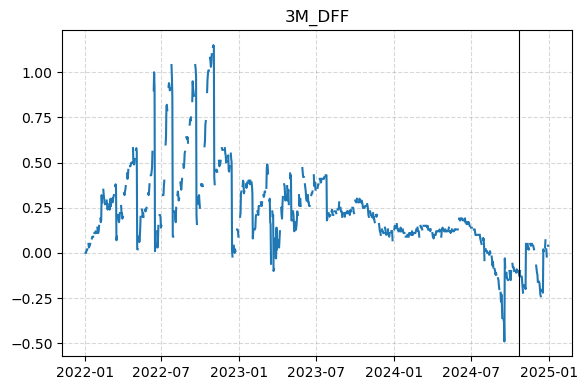

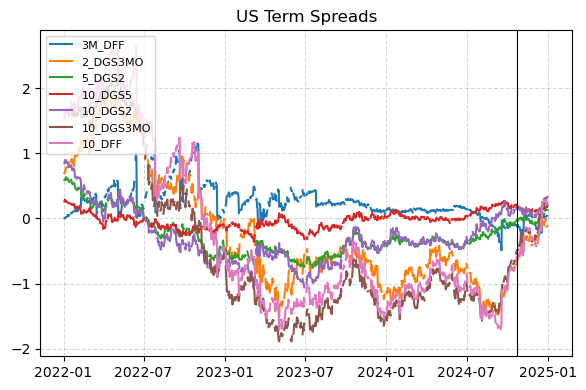

In [18]:
# US term spread charts

# Extract column names from the DataFrame
us_term_spreads_ids = ["10_DGS5","10_DGS2","10_DGS3MO","10_DFF",
                      "5_DGS2","5_DGS3MO","5_DFF",
                      "2_DGS3MO","2_DFF",
                      "3M_DFF"]

# Set chart parameters
vline = ["2024-10-23"]
custom_dates = ["2024-12-11", "2024-10-23","2024-09-4","2024-07-24","2024-04-10"]  # dates to include in tables
start_date = "2022-01-01"

# Loop to create individual charts for each series
for series in us_term_spreads_ids:
    create_chart(us_term_spreads, [series], start_date=start_date, show_data_label=False,
                 title=None, vlines=vline, show_table=False, custom_dates=custom_dates,
                 save_path=f"{results_dir}/{series}_chart.png")

ts_chart = ["3M_DFF","2_DGS3MO","5_DGS2","10_DGS5","10_DGS2","10_DGS3MO","10_DFF"]

# Create a single chart for the entire group
create_chart(us_term_spreads, ts_chart, start_date=start_date, title="US Term Spreads",
             show_data_label=False, vlines=vline, show_table=False, custom_dates=custom_dates,
             save_path=f"{results_dir}/us_term_spreads_chart.png")


# US Corp Yields Charts and Tables

Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/BAMLC0A1CAAAEY_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/BAMLC0A2CAAEY_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/BAMLC0A3CAEY_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/BAMLC0A4CBBBEY_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/BAMLH0A1HYBBEY_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/BAMLH0A2HYBEY_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/BAMLH0A3HYCEY_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/us_corp_yields_chart.png


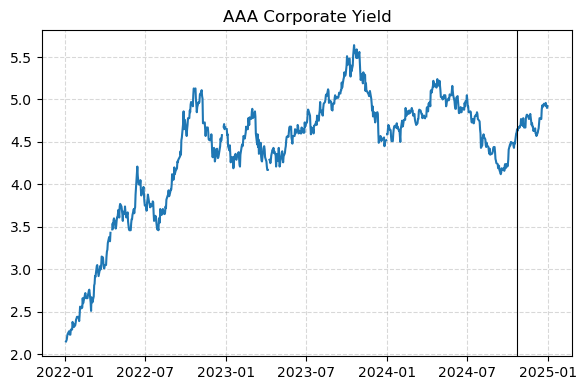

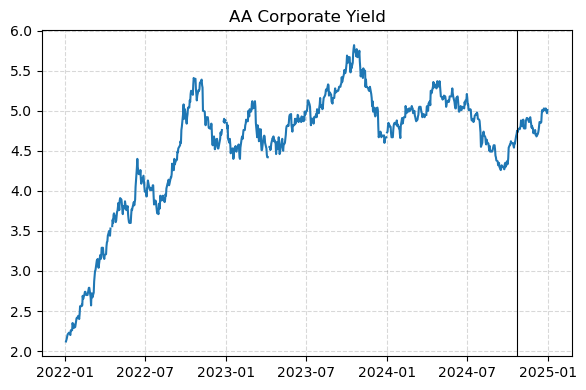

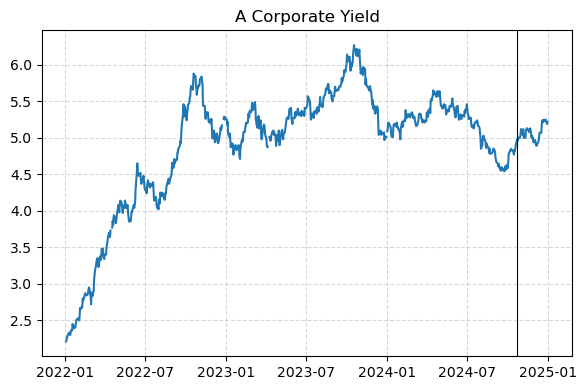

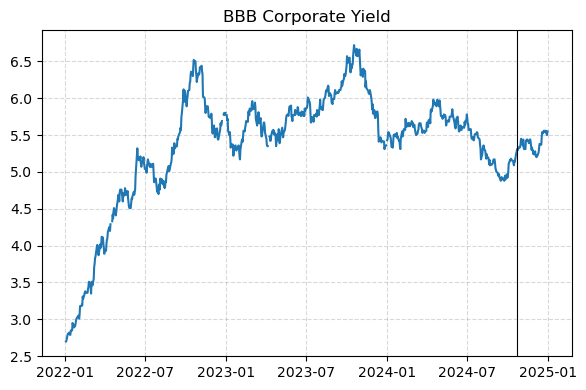

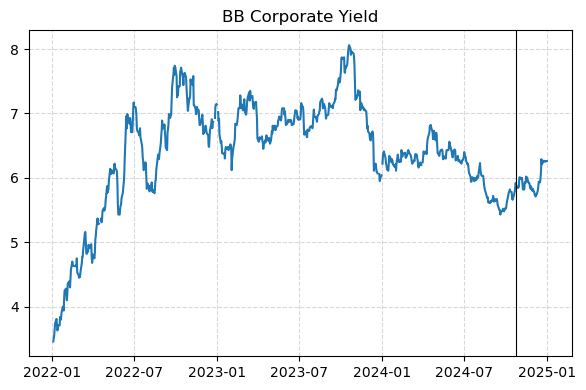

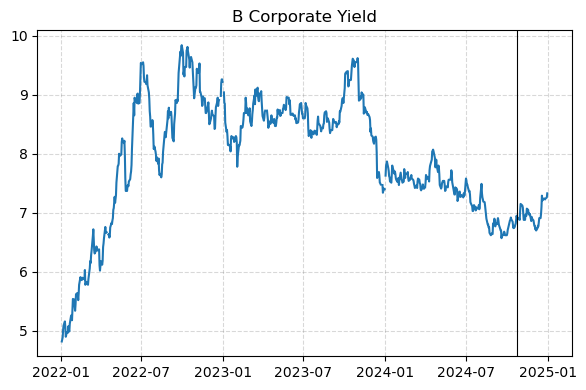

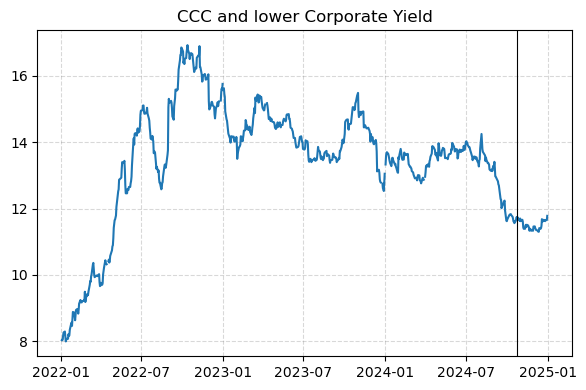

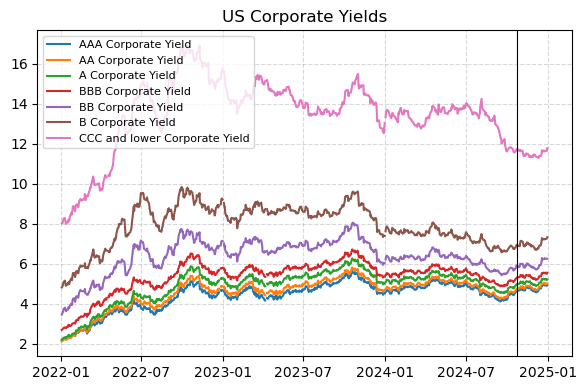

In [19]:
# US corp yields charts

# Extract column names from the DataFrame
us_corp_yields_ids = us_corp_yields.columns.tolist()

# Set chart parameters
vline = ["2024-10-23"]
custom_dates = ["2024-12-11", "2024-10-23","2024-09-4","2024-07-24","2024-04-10"]  # dates to include in tables
start_date = "2022-01-01"

# Loop to create individual charts for each series
for series in us_corp_yields_ids:
    create_chart(us_corp_yields, [series], start_date=start_date, show_data_label=False,
                 title=None, vlines=vline, show_table=False, custom_dates=custom_dates,
                 save_path=f"{results_dir}/{series}_chart.png")

# Create a single chart for the entire group
create_chart(us_corp_yields, us_corp_yields_ids, start_date=start_date, title="US Corporate Yields",
             show_data_label=False, vlines=vline, show_table=False, custom_dates=custom_dates,
             save_path=f"{results_dir}/us_corp_yields_chart.png")


In [20]:
# All corp yields table
title = ""
output_file = f"{results_dir}/us_corp_yields_table.png"

create_comparison_table(us_corp_yields, us_corp_yields_ids, custom_dates, title, output_file)


Table saved to /data/data/com.termux/files/home/projects/fred_data_project/results/us_corp_yields_table.png


# US Corp Spread Charts and Tables

Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/BAMLC0A1CAAA_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/BAMLC0A2CAA_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/BAMLC0A3CA_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/BAMLC0A4CBBB_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/BAMLH0A1HYBB_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/BAMLH0A2HYB_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/BAMLH0A3HYC_chart.png
Chart saved to: /data/data/com.termux/files/home/projects/fred_data_project/results/us_corp_spreads_chart.png


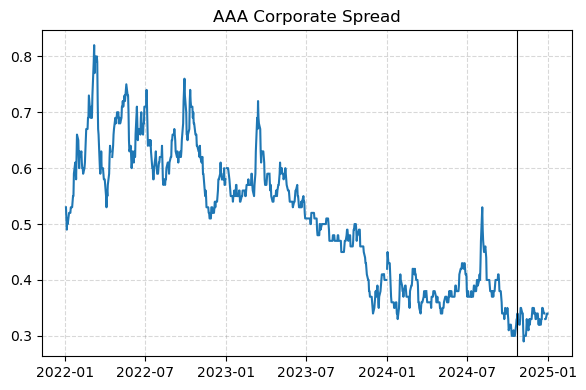

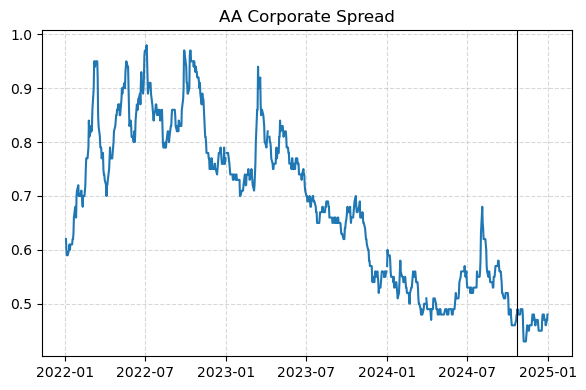

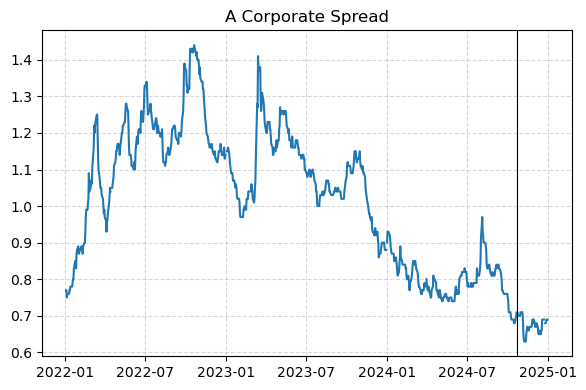

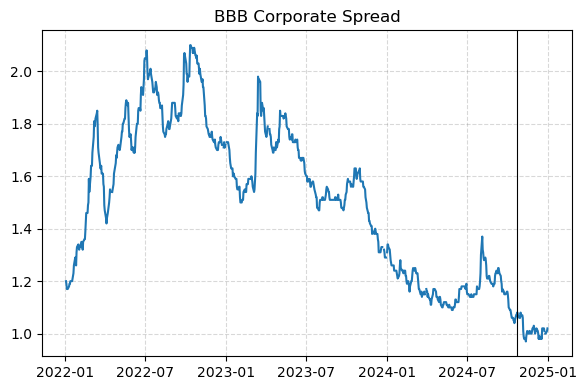

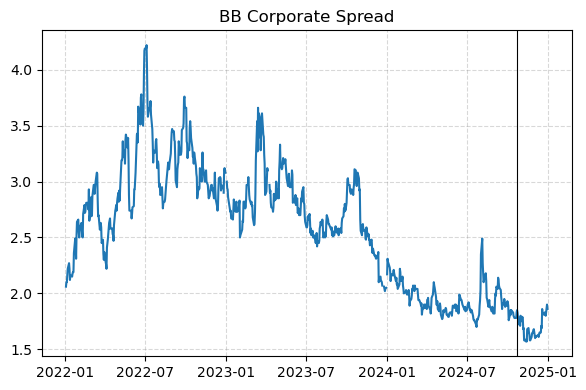

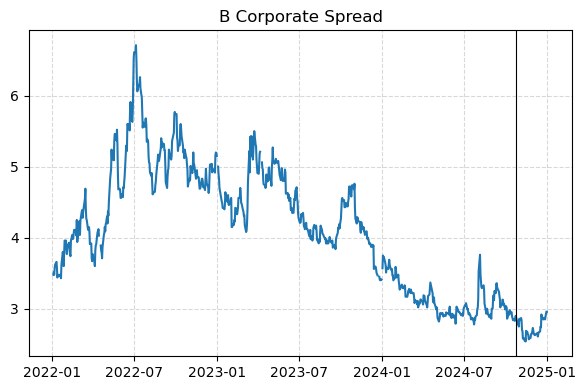

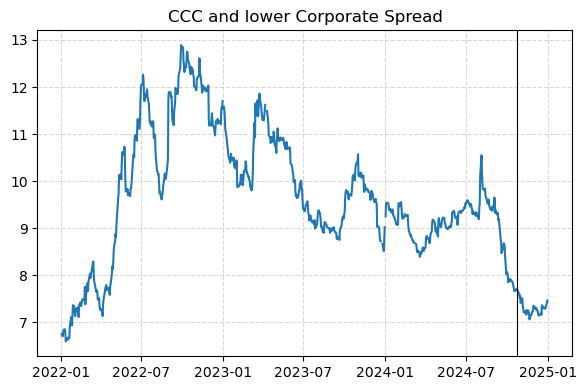

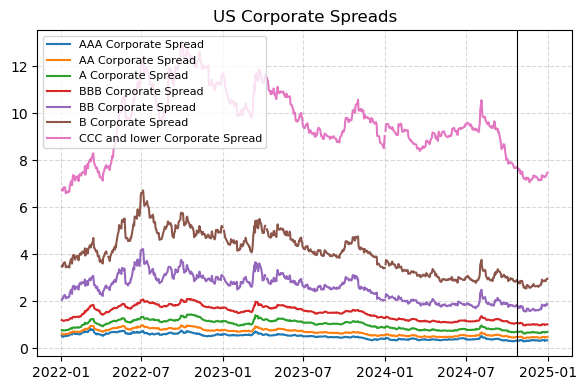

In [21]:
# US corp spread charts

# Extract column names from the DataFrame
us_corp_spreads_ids = us_corp_spreads.columns.tolist()

# Set chart parameters
vline = ["2024-10-23"]
custom_dates = ["2024-12-11", "2024-10-23","2024-09-4","2024-07-24","2024-04-10"]  # dates to include in tables
start_date = "2022-01-01"

# Loop to create individual charts for each series
for series in us_corp_spreads_ids:
    create_chart(us_corp_spreads, [series], start_date=start_date, show_data_label=False,
                 title=None, vlines=vline, show_table=False, custom_dates=custom_dates,
                 save_path=f"{results_dir}/{series}_chart.png")

# Create a single chart for the entire group
create_chart(us_corp_spreads, us_corp_spreads_ids, start_date=start_date, title="US Corporate Spreads",
             show_data_label=False, vlines=vline, show_table=False, custom_dates=custom_dates,
             save_path=f"{results_dir}/us_corp_spreads_chart.png")


In [22]:
# All corp spreads table
title = ""
output_file = f"{results_dir}/us_corp_spreads_table.png"

create_comparison_table(us_corp_spreads, us_corp_spreads_ids, custom_dates, title, output_file)


Table saved to /data/data/com.termux/files/home/projects/fred_data_project/results/us_corp_spreads_table.png


# Reporting

In [23]:
# Report 
sections = [
    {
        'title': 'US Government Yields',
        'image_configs': [
            [f"{results_dir}/DFF_chart.png",f"{results_dir}/DGS3MO_chart.png"],
            [f"{results_dir}/DGS2_chart.png", f"{results_dir}/DGS5_chart.png"],
            [f"{results_dir}/DGS10_chart.png",f"{results_dir}/us_yields_chart.png"],
            f"{results_dir}/us_yields_table.png",
            [f"{results_dir}/DGS2_table.png",f"{results_dir}/DGS10_table.png"]# Two images in one row
        ]
    },
    {
        'title': 'US Corporate Yields (ICE BoA)',
        'image_configs': [
            [f"{results_dir}/BAMLC0A1CAAAEY_chart.png",f"{results_dir}/BAMLC0A4CBBBEY_chart.png"],
            [f"{results_dir}/BAMLH0A3HYCEY_chart.png",f"{results_dir}/us_corp_yields_chart.png"],
            f"{results_dir}/us_corp_yields_table.png"
        ]
    }
]

# Create the report
create_report(
    'market_update.pdf',
    sections,
    report_title='Market Update'
)